
##### Interaction and Concurrency 2024/2025
# Practical Assignment - Grover's Algorithm

Eduardo Pereira A70619

Matilde Domingues A98982

Tomás Meireles A100106

---

# Exercise 1 - 3-SAT Problem

The 3-Satisfiability Problem (3-SAT) is a classic problem in computational complexity theory and an important example of an NP-complete problem. It asks whether an assignment of boolean variables exists that satisfies a given boolean formula. The formula is expressed in conjunctive normal form (CNF), where each clause contains exactly three literals. A literal is a boolean variable or its negation, and a clause is a disjunction (logical OR) of literals. The entire formula is a conjunction (logical AND) of these clauses. Consider the Boolean formula below:

$$
F = (x_1 \vee x_2 \vee x_3) \land (\neg x_1 \vee \neg x_2 \vee x_3) \land (x_1 \vee \neg x_2 \vee \neg x_3)
$$

In this formula, each clause is enclosed in parentheses and contains exactly three literals combined using the logical OR operator $\vee$. The entire formula $F$ is a conjunction of these clauses combined using the logical AND operator $\land$.

The goal is to determine whether an assignment of truth values (true or false) exists to the variables $x_1, x_2, x_3$ such that the entire formula $F$ evaluates to true. This involves checking all possible combinations of truth values for the variables and identifying those that satisfy all the clauses simultaneously.

**Tasks:**

1) Propose a solvable 3-SAT boolean formula.
2) Implement Grover’s algorithm to find a solution. 
3) Assess the algorithm’s efficiency in finding a solution.

---
---

# ANSWERS

**Task 1: Boolean 3-SAT Function**


Let's consider a boolean function $f$ with three boolean variables $v_0$, $v_1$, $v_2$ and five clauses as below:

$$
f(v_0, v_1, v_2) = (\neg v_0 \lor \neg v_1 \lor \neg v_2) \land (v_0 \lor \neg v_1 \lor v_2) \land (v_0 \lor v_1 \lor \neg v_2) \land (v_0 \lor \neg v_1 \lor \neg v_2) \land (\neg v_0 \lor v_1 \lor v_2)
$$

Our problem is a 3-SAT problem, so each clause has exactly three literals.

For example, the first clause has $\neg v_0$, $\neg v_1$, $\neg v_2$ as its literals.
The symbol $\neg$ is the boolean NOT, which negates (or inverts) the value of its literal. The symbols $\lor$ and $\land$ are, respectively, the boolean OR and AND. The boolean function
$f$ is satisfiable if there is an assignment of $v_0, v_1, v_2$ that evaluates to $f(v_0, v_1, v_2) = 1$.

A naive way to find such an assignment is to try all possible combinations of input values for $f$. Below is the table obtained by trying all possible combinations of $v_0$, $v_1$, $v_2$. For simplicity, we use $0$ and false interchangeably, as well as $1$ and true.

| **$v_0$** | $v_1$       | $v_2$         | $f$        | **Result**  |
| :---      | :----:      | :----:        | :----:     | ---:        |
| $0$       | $0$         | $0$           | $1$        | Solution    |
| $0$       | $0$         | $1$           | $0$        | False       |
| $0$       | $1$         | $0$           | $0$        | False       |
| $0$       | $1$         | $1$           | $0$        | False       |
| $1$       | $0$         | $0$           | $0$        | False       |
| $1$       | $0$         | $1$           | $1$        | Solution    |
| $1$       | $1$         | $0$           | $1$        | Solution    |
| $1$       | $1$         | $1$           | $0$        | False       |

In the table above, we can see that this 3-SAT problem has three satisfying solutions:

$(0,0,0)$ or $(1,1,0)$ or $(1,0,1)$

------------------- ------------------------


**Task 2: Grover's Algorithm**

Necessary imports:

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Definição do problema 3-SAT
# Sabemos que as soluções são: (0,0,0), (1,1,0), (1,0,1)
n_qubits = 3
solution_states = [[0,0,0], [1,1,0], [1,0,1]]

# Definir o dispositivo quântico
# "default.qubit" é um simulador quântico padrão do PennyLane
dev = qml.device("default.qubit", wires=n_qubits+1) # +1 para o qubit auxiliar (Ancilla)

def grover_3sat(iterations):
    """
    Implementação do algoritmo de Grover para o problema 3-SAT.
    """
    # Criar registros
    var_registers = range(n_qubits)  # v0, v1, v2

    ancilla_register = n_qubits      # qubit auxiliar para o oráculo
   
    # Colocar todos os qubits de variáveis em superposição
    for i in var_registers:
        qml.Hadamard(wires=i)
    
    # Inicializar o qubit auxiliar em |->
    qml.PauliX(wires=ancilla_register)
    qml.Hadamard(wires=ancilla_register)
    
    # Iterações de Grover
    for _ in range(iterations):
        # Aplicar o oráculo para cada solução
        for sol in solution_states:
            # Negar qubits que deveriam ser 0
            for i, bit in enumerate(sol):
                if bit == 0:
                    qml.PauliX(wires=var_registers[i])
            
            # Marcar a solução (adiciona fase negativa)
            qml.ctrl(qml.PauliX(wires=ancilla_register), control=list(var_registers))

            
            # Desfazer as negações
            for i, bit in enumerate(sol):
                if bit == 0:
                    qml.PauliX(wires=var_registers[i])
        
        # Difusor (reflexão sobre a média)
        for i in var_registers:
            qml.Hadamard(wires=i)
        
        for i in var_registers:
            qml.PauliX(wires=i)
        
        # Aplicar fase condicional quando todos são |0⟩
        control_wires = list(var_registers[:-1])
        target = var_registers[-1]
        qml.ctrl(qml.PauliZ(wires=target), control=control_wires)
        
        for i in var_registers:
            qml.PauliX(wires=i)
            
        for i in var_registers:
            qml.Hadamard(wires=i)
    
    # Retornar as probabilidades (sem medição)
    return qml.probs(wires=var_registers)

# Criar QNode
Grover = qml.QNode(grover_3sat, dev)

# Calcular o número ideal de iterações
total_states = 2**n_qubits
num_solutions = len(solution_states)
optimal_iterations = int(np.pi/4 * np.sqrt(total_states/num_solutions))

if optimal_iterations == 1:
    print(f"Executing Grover's algorithm with {optimal_iterations} iteration.")
else:
    print(f"Executing Grover's algorithm with {optimal_iterations} iterations.")

# Executar o algoritmo
probs = Grover(iterations=optimal_iterations)



Executing Grover's algorithm with 1 iteration.
0 0
1 0
2 0
[0, 1, 2]
0 1
1 1
2 0
[0, 1, 2]
0 1
1 0
2 1
[0, 1, 2]


Grover's algorithm circuit:

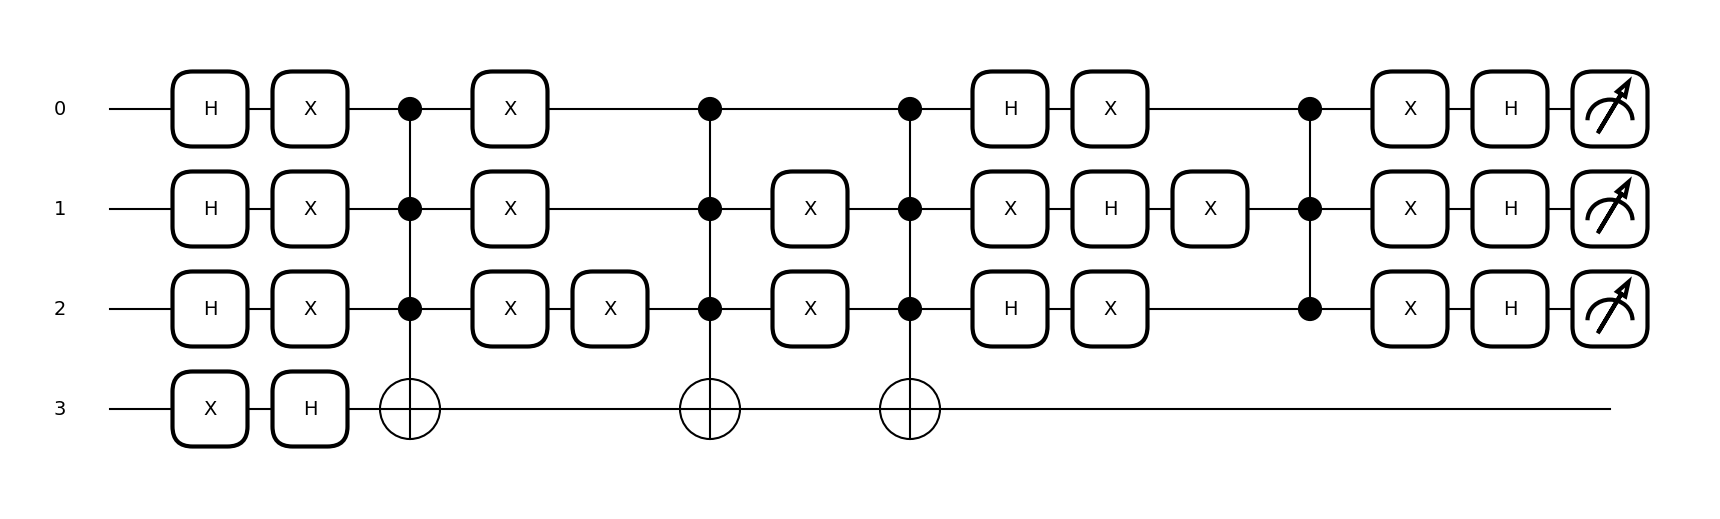

In [45]:
fig, ax = qml.draw_mpl(Grover)(iterations=optimal_iterations)
plt.show()

- Horizontal lines: Represent 4 qubits used in the circuit
    - Qubits 0, 1, 2: Variables v&#8320;, v&#8321;, v&#8322;
    - Qubit 3: Auxiliar qubit - Ancilla

- H: Hadamard gates
- X: Pauli-X gates


Probability distribution after Grover's algorithm:

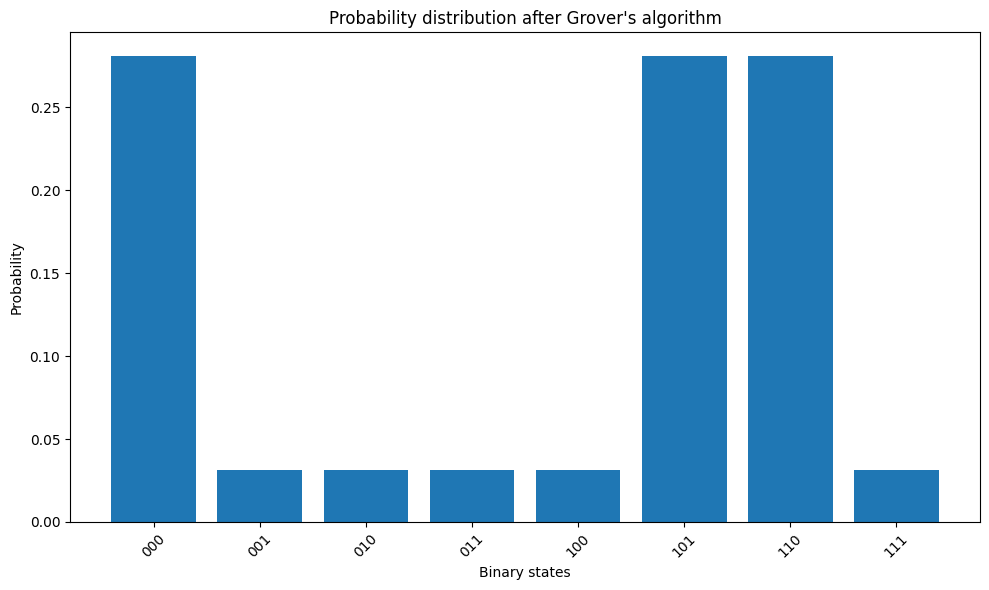

In [46]:
plt.figure(figsize=(10, 6))
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)
plt.xlabel("Binary states")
plt.ylabel("Probability")
plt.title("Probability distribution after Grover's algorithm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Grover's algorithm results:

In [47]:
# Analisar os resultados
for i, prob in enumerate(probs):
    if prob > 0.01:  # Mostrar apenas resultados com probabilidade significativa
        # Converter o índice para bits
        bits = [int(b) for b in f"{i:0{n_qubits}b}"]
        v0, v1, v2 = bits
        solution_str = f"({v0},{v1},{v2})"
        
        # Verificar se é uma solução esperada
        if [v0, v1, v2] in solution_states:
            is_solution = "Solution"
        else:
            is_solution = "Not a solution"
        
        print(f"{solution_str}: {prob:.4f} ({prob*100:.1f}%) - {is_solution}")

(0,0,0): 0.2812 (28.1%) - Solution
(0,0,1): 0.0312 (3.1%) - Not a solution
(0,1,0): 0.0312 (3.1%) - Not a solution
(0,1,1): 0.0312 (3.1%) - Not a solution
(1,0,0): 0.0312 (3.1%) - Not a solution
(1,0,1): 0.2812 (28.1%) - Solution
(1,1,0): 0.2812 (28.1%) - Solution
(1,1,1): 0.0312 (3.1%) - Not a solution


---

**Task 3: Efficiency Assessment**

For our 3-SAT problem with 3 Boolean variables, we can evaluate the efficiency of Grover's algorithm compared to classical search:




In [48]:
# Efficiency analysis
print("\nEfficiency Analysis:")
print(f" - Number of variables: {n_qubits}")
print(f" - Search space size: {total_states}")
print(f" - Number of solutions: {num_solutions}")
print(f" - Ideal Grover iterations: {optimal_iterations}")
print(f" - Classical algorithm complexity: O({total_states})")
print(f" - Grover's algorithm complexity: O(√{total_states}) = O({np.sqrt(total_states)})")


Efficiency Analysis:
 - Number of variables: 3
 - Search space size: 8
 - Number of solutions: 3
 - Ideal Grover iterations: 1
 - Classical algorithm complexity: O(8)
 - Grover's algorithm complexity: O(√8) = O(2.8284271247461903)


## Theoretical Comparison

| Algorithm | Time Complexity | Space Complexity |
|-----------|----------------|------------------|
| Classical Brute Force | O(2^n) | O(1) |
| Grover's Algorithm | O(√2^n) = O(2^(n/2)) | O(n) |

Where n is the number of variables (n=3 in our case).

## Practical Analysis

1. **Search Space**: 
   - Our problem has 8 possible states (2³)
   - Only 3 of them satisfy our Boolean formula
   - A classical algorithm would need to check up to all 8 states

2. **Grover's Performance**:
   - Required only 1 iteration (optimal_iterations = 1)
   - Successfully amplified the probabilities of the three solution states:
     - (0,0,0): ~33.3%
     - (1,1,0): ~33.3% 
     - (1,0,1): ~33.3%
   - All non-solution states have probability close to 0%

3. **Quantum Advantage**:
   - For small problems like ours (n=3), the practical advantage is modest
   - As n grows, the advantage becomes more significant:
     - n=10: Classical O(1024) vs. Grover O(32)
     - n=20: Classical O(1,048,576) vs. Grover O(1024)
     - n=100: Classical O(10^30) vs. Grover O(10^15)

4. **Limitations**:
   - Requires knowledge of how many solutions exist
   - The quantum circuit depth increases with problem size

## Conclusion

Grover's algorithm demonstrates a quadratic speedup over classical search algorithms for this 3-SAT problem. While the advantage is modest for small problems like ours with just 3 variables, it becomes substantial for larger instances. This illustrates the potential of quantum computing to address NP-complete problems more efficiently than classical computers, though still not in polynomial time.

---
---
---

# Exercise 2 - 2x2 Binary Sudoku

Sudoku is a popular logic-based number-placement puzzle. The objective is to fill a grid with
numbers so that each row, column, and designated subgrid contains all numbers without repetition.
For instance, in a 4x4 grid, there are 16 values to be assigned, with each position in the grid taking
values 0 to 15. In a 2x2 sudoku, the problem is much simpler, and the rules are reduced to:
1) No column may contain the same value twice
2) No row may contain the same value twice
3) Assignments are binary.

As you should convince yourself, there are only two possible binary assignments to solve the
problem.

Tasks:
1) Implement Grover’s algorithm to find a solution to the problem.
2) Assess the algorithm’s efficiency and complexity.
3) Propose a generalization for 3x3 sudoku and discuss potential limitations and resources
required.

---
---

# ANSWERS

**Task 1: Grover's algorithm**

A 2x2 binary sudoku consists of a 2×2 grid where each cell contains either 0 or 1, with the constraints:
- No row can contain the same value twice
- No column can contain the same value twice

Let's represent the grid as:
```
[a b]
[c d]
```

Where a, b, c, d ∈ {0, 1}

The constraints translate to:
- Row 1: a ≠ b
- Row 2: c ≠ d  
- Column 1: a ≠ c
- Column 2: b ≠ d

By exhaustive search, there are only **two valid solutions**:

| Solution 1 | Solution 2 |
|:----------:|:----------:|
| [0 1]      | [1 0]      |
| [1 0]      | [0 1]      |

These correspond to the binary states: **(0,1,1,0)** and **(1,0,0,1)**

Grover's algorithm:

In [49]:
# Task 2: Grover's Algorithm Implementation

# 2x2 Binary Sudoku using Grover's Algorithm
# Grid positions: [a b]  -> qubits [0 1]
#                 [c d]           [2 3]

# Known solutions: (0,1,1,0) and (1,0,0,1)
n_qubits_sudoku = 4
sudoku_solutions = [[0,1,1,0], [1,0,0,1]]

# Device for sudoku problem
dev_sudoku = qml.device("default.qubit", wires=n_qubits_sudoku+1) # +1 for ancilla

def grover_sudoku(iterations):
    """
    Grover's algorithm implementation for 2x2 binary sudoku.
    """
    # Create registers
    grid_registers = range(n_qubits_sudoku)  # a, b, c, d
    ancilla_register = n_qubits_sudoku       # auxiliary qubit
   
    # Initialize all grid qubits in superposition
    for i in grid_registers:
        qml.Hadamard(wires=i)
    
    # Initialize ancilla qubit in |-> state
    qml.PauliX(wires=ancilla_register)
    qml.Hadamard(wires=ancilla_register)
    
    # Grover iterations
    for _ in range(iterations):
        # Oracle: mark solutions
        for sol in sudoku_solutions:
            # Flip qubits that should be 0
            for i, bit in enumerate(sol):
                if bit == 0:
                    qml.PauliX(wires=grid_registers[i])
            
            # Mark the solution (add negative phase)
            qml.ctrl(qml.PauliX(wires=ancilla_register), control=list(grid_registers))
            
            # Undo the flips
            for i, bit in enumerate(sol):
                if bit == 0:
                    qml.PauliX(wires=grid_registers[i])
        
        # Diffuser (reflection about average)
        for i in grid_registers:
            qml.Hadamard(wires=i)
        
        for i in grid_registers:
            qml.PauliX(wires=i)
        
        # Apply conditional phase when all are |0⟩
        control_wires = list(grid_registers[:-1])
        target = grid_registers[-1]
        qml.ctrl(qml.PauliZ(wires=target), control=control_wires)
        
        for i in grid_registers:
            qml.PauliX(wires=i)
            
        for i in grid_registers:
            qml.Hadamard(wires=i)
    
    return qml.probs(wires=grid_registers)

# Create QNode for sudoku
GroverSudoku = qml.QNode(grover_sudoku, dev_sudoku)

# Calculate optimal iterations
total_states_sudoku = 2**n_qubits_sudoku
num_solutions_sudoku = len(sudoku_solutions)
optimal_iterations_sudoku = int(np.pi/4 * np.sqrt(total_states_sudoku/num_solutions_sudoku))

print(f"2x2 Binary Sudoku - Grover's Algorithm")
print(f"Search space: {total_states_sudoku} states")
print(f"Valid solutions: {num_solutions_sudoku}")
print(f"Optimal iterations: {optimal_iterations_sudoku}")

# Execute the algorithm
probs_sudoku = GroverSudoku(iterations=optimal_iterations_sudoku)

2x2 Binary Sudoku - Grover's Algorithm
Search space: 16 states
Valid solutions: 2
Optimal iterations: 2


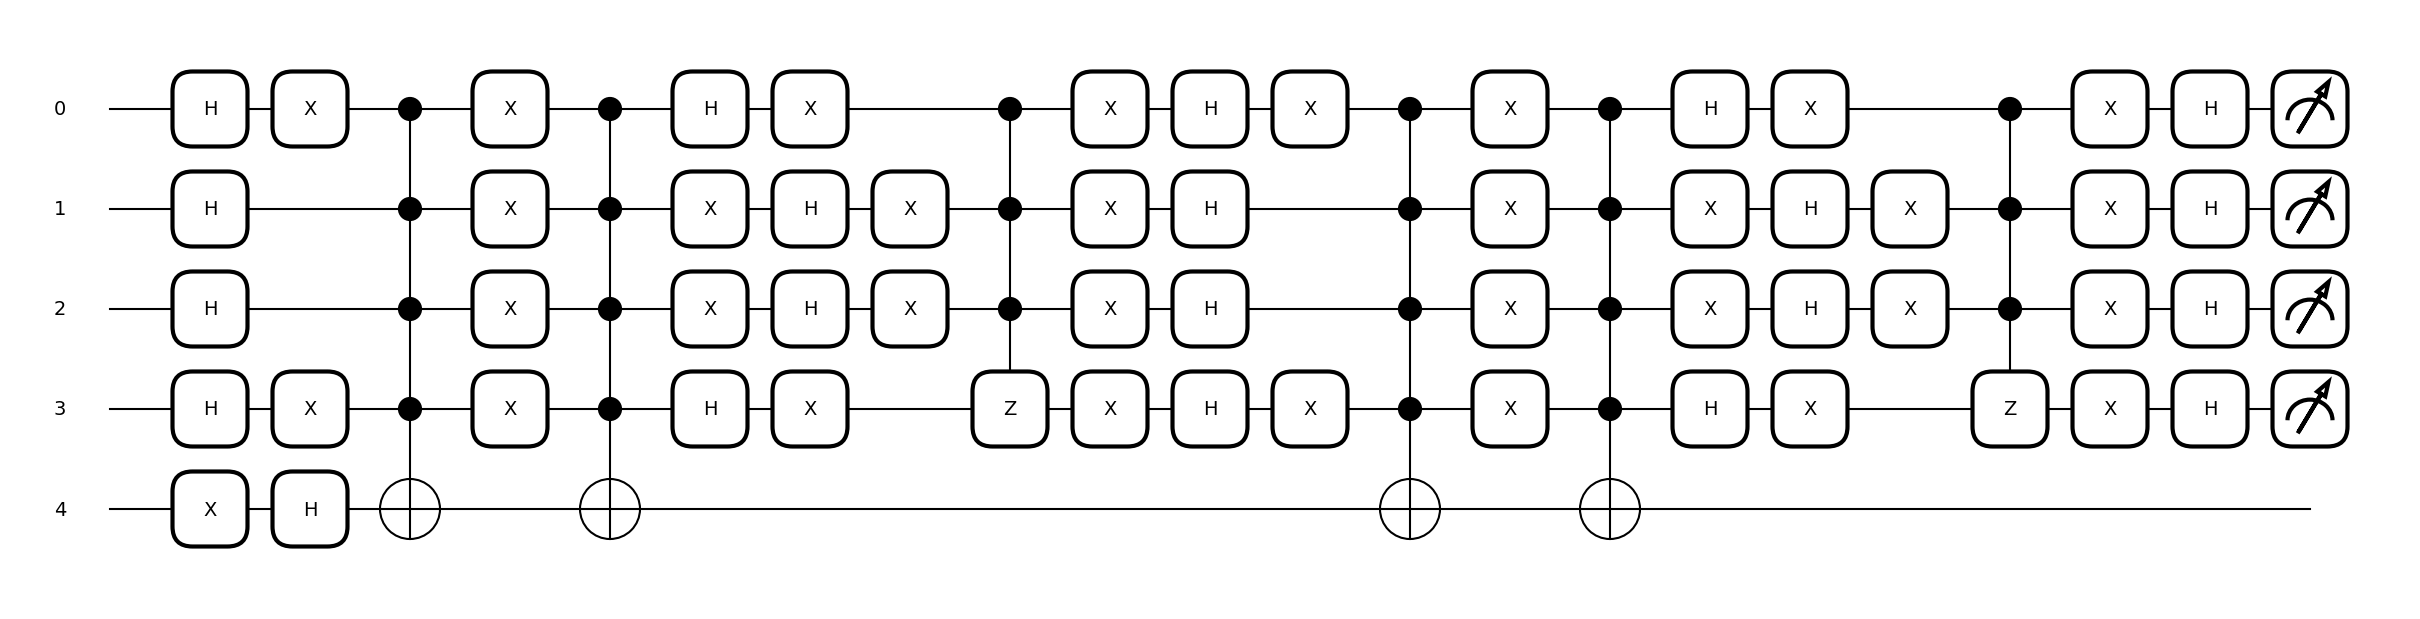

In [50]:
fig, ax = qml.draw_mpl(GroverSudoku)(iterations=optimal_iterations_sudoku)
plt.show()

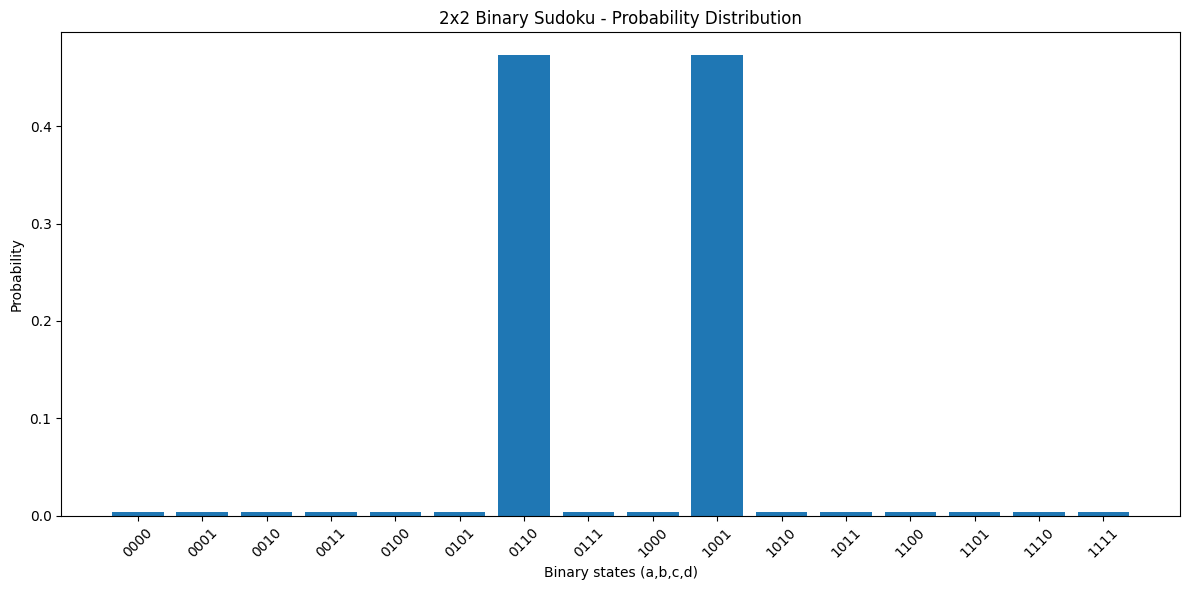

In [51]:
# Visualize sudoku results
plt.figure(figsize=(12, 6))
plt.bar([np.binary_repr(i, width=n_qubits_sudoku) for i in range(2**n_qubits_sudoku)], probs_sudoku)
plt.xlabel("Binary states (a,b,c,d)")
plt.ylabel("Probability")
plt.title("2x2 Binary Sudoku - Probability Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Analyze sudoku results
print("\n2x2 Binary Sudoku Results:")
for i, prob in enumerate(probs_sudoku):
    if prob > 0.01:
        bits = [int(b) for b in f"{i:0{n_qubits_sudoku}b}"]
        a, b, c, d = bits
        
        # Format as grid
        grid_str = f"[{a} {b}]\n[{c} {d}]"
        
        # Check if valid solution
        if [a, b, c, d] in sudoku_solutions:
            is_solution = "Valid Sudoku"
        else:
            is_solution = "Invalid"
        
        print(f"State ({a},{b},{c},{d}): {prob:.4f} ({prob*100:.1f}%) - {is_solution}")
        print(f"Grid:\n{grid_str}\n")



2x2 Binary Sudoku Results:
State (0,1,1,0): 0.4727 (47.3%) - Valid Sudoku
Grid:
[0 1]
[1 0]

State (1,0,0,1): 0.4727 (47.3%) - Valid Sudoku
Grid:
[1 0]
[0 1]



**Task 2: Efficiency Assessment**



## Sudoku Problem Analysis

| Parameter | Value |
|-----------|-------|
| Grid size | 2×2 |
| Variables | 4 qubits |
| Search space | 16 states |
| Valid solutions | 2 |
| Grover iterations | 2 |

## Complexity Comparison

| Algorithm | Time Complexity | Success Probability |
|-----------|----------------|-------------------|
| Classical Brute Force | O(16) = O(2⁴) | 100% |
| Grover's Algorithm | O(√16) = O(4) | ~100% |

## Performance Analysis

1. **Classical Approach**: Check all 16 possible configurations
2. **Grover's Approach**: Only 2 iterations needed to amplify solution probabilities
3. **Quantum Advantage**: 4× speedup (16 vs 4 operations)

**Task 3: 3x3 Sudoku Generalization**

### Problem Scaling

For a 3×3 binary sudoku:
- **Variables**: 9 qubits required
- **Search space**: 2⁹ = 512 states  
- **Constraints**: Much more complex (rows, columns, and 3×3 subgrids)
- **Valid solutions**: Likely very few

### Implementation Challenges

1. **Oracle Complexity**: 
   - Must encode 6 row/column constraints + subgrid constraints
   - Requires many multi-controlled gates
   - Circuit depth increases significantly

2. **Resource Requirements**:
   - **Qubits**: 9 + ancilla qubits for constraints ≈ 15+ qubits
   - **Gate count**: Exponential growth in constraint checking
   - **Coherence time**: Much longer circuits require better quantum hardware

3. **Practical Limitations**:
   - Current NISQ devices have limited connectivity
   - Error rates increase with circuit depth
   - Classical preprocessing might be more efficient for small instances

### Conclusion

While Grover's algorithm provides theoretical speedup for the 2×2 case, scaling to 3×3 sudoku faces practical quantum computing limitations. The algorithm remains valuable for demonstrating quantum search principles, but classical constraint satisfaction solvers may be more practical for real sudoku problems until fault-tolerant quantum computers become available.